# Feature Engineering for 911 Call Prediction

This notebook creates rich features from Priority Level, Mental Health Flag, and Incident Category to enhance model performance.

## Strategy

Instead of aggregating by Priority/Mental Health (which creates sparsity), we:
- **Target**: Total call count per sector/day (or sector/week)
- **Features**: Percentage of Priority 1 calls, % Mental Health calls, top incident categories, lag features, etc.

This approach maintains good target variable distribution while adding predictive power.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.style.use('default')


## Load Original Data

Load the raw dataset with Priority Level, Mental Health Flag, and Incident Category.


In [2]:
# Load original data
data = pd.read_csv('export.csv')

# Extract relevant columns
df = data[['Mental Health Flag', 'Priority Level', 'Response Datetime', 
           'Response Day of Week', 'Response Hour', 'Sector', 'Geo ID', 
           'Initial Problem Category']].copy()

# Remove missing values
df = df.dropna()

# Parse datetime
df['Response Datetime'] = pd.to_datetime(df['Response Datetime'])
df['Date'] = df['Response Datetime'].dt.date
df['Month'] = df['Response Datetime'].dt.month
df['Year'] = df['Response Datetime'].dt.year
df['Day_of_Year'] = df['Response Datetime'].dt.dayofyear
df['Week'] = df['Response Datetime'].dt.isocalendar().week

print(f"Total records: {len(df):,}")
print(f"Date range: {df['Response Datetime'].min()} to {df['Response Datetime'].max()}")
print(f"\nPriority Levels: {df['Priority Level'].unique()}")
print(f"Mental Health values: {df['Mental Health Flag'].unique()}")
print(f"Unique Categories: {df['Initial Problem Category'].nunique()}")


Total records: 812,576
Date range: 2023-01-01 00:01:00 to 2025-10-31 23:59:47

Priority Levels: ['Priority 2' 'Priority 0' 'Priority 3' 'Priority 1']
Mental Health values: ['Not Mental Health Incident' 'Mental Health Incident']
Unique Categories: 40


## Create Daily Aggregations with Features

Aggregate to daily level and calculate feature columns from Priority, Mental Health, and Category.


In [3]:
# Sector Daily Aggregation
sector_daily = df.groupby(['Sector', 'Date', 'Response Day of Week', 'Month', 'Year', 
                           'Day_of_Year', 'Week']).agg({
    'Priority Level': 'count',  # Total calls
    'Mental Health Flag': lambda x: (x == 'Mental Health Incident').sum(),  # Count MH calls
    'Response Hour': 'mean'  # Average hour (we'll recalculate this properly)
}).reset_index()

sector_daily.columns = ['Sector', 'Date', 'Response Day of Week', 'Month', 'Year', 
                        'Day_of_Year', 'Week', 'Total_Calls', 'MH_Count', 'Avg_Hour']

# Calculate Priority distribution
priority_daily = df.groupby(['Sector', 'Date', 'Priority Level']).size().reset_index(name='Count')
priority_daily_pivot = priority_daily.pivot_table(
    index=['Sector', 'Date'], 
    columns='Priority Level', 
    values='Count', 
    fill_value=0
).reset_index()
priority_daily_pivot.columns = ['Sector', 'Date', 'Priority_1', 'Priority_2', 'Priority_3', 'Priority_4']
priority_daily = priority_daily_pivot

# Merge priority features
sector_daily = sector_daily.merge(priority_daily, on=['Sector', 'Date'], how='left')

# Calculate percentages
sector_daily['pct_priority_1'] = sector_daily['Priority_1'] / sector_daily['Total_Calls']
sector_daily['pct_priority_2'] = sector_daily['Priority_2'] / sector_daily['Total_Calls']
sector_daily['pct_priority_3'] = sector_daily['Priority_3'] / sector_daily['Total_Calls']
sector_daily['pct_priority_4'] = sector_daily['Priority_4'] / sector_daily['Total_Calls']
sector_daily['pct_mental_health'] = sector_daily['MH_Count'] / sector_daily['Total_Calls']

# Fill NaN with 0 (for days with no calls of that type)
sector_daily[['pct_priority_1', 'pct_priority_2', 'pct_priority_3', 'pct_priority_4', 
              'pct_mental_health']] = sector_daily[['pct_priority_1', 'pct_priority_2', 
              'pct_priority_3', 'pct_priority_4', 'pct_mental_health']].fillna(0)

# Rename target
sector_daily = sector_daily.rename(columns={'Total_Calls': 'Call_Count'})

print(f"Sector Daily shape: {sector_daily.shape}")
print(f"\nColumns: {list(sector_daily.columns)}")
print(f"\nSample:")
print(sector_daily.head())


Sector Daily shape: (10351, 19)

Columns: ['Sector', 'Date', 'Response Day of Week', 'Month', 'Year', 'Day_of_Year', 'Week', 'Call_Count', 'MH_Count', 'Avg_Hour', 'Priority_1', 'Priority_2', 'Priority_3', 'Priority_4', 'pct_priority_1', 'pct_priority_2', 'pct_priority_3', 'pct_priority_4', 'pct_mental_health']

Sample:
  Sector        Date Response Day of Week  Month  Year  Day_of_Year  Week  \
0   Adam  2023-01-01                  Sun      1  2023            1    52   
1   Adam  2023-01-02                  Mon      1  2023            2     1   
2   Adam  2023-01-03                  Tue      1  2023            3     1   
3   Adam  2023-01-04                  Wed      1  2023            4     1   
4   Adam  2023-01-05                  Thu      1  2023            5     1   

   Call_Count  MH_Count   Avg_Hour  Priority_1  Priority_2  Priority_3  \
0          85        10  12.070588        19.0        20.0        37.0   
1          84         7  13.916667         6.0        12.0        41

## Add Top Incident Categories

Identify top 5 incident categories and create one-hot features.


In [4]:
# Find top 5 categories overall
top_categories = df['Initial Problem Category'].value_counts().head(5).index.tolist()
print(f"Top 5 Incident Categories: {top_categories}")

# Calculate category counts per sector-date
for i, category in enumerate(top_categories, 1):
    cat_counts = df[df['Initial Problem Category'] == category].groupby(
        ['Sector', 'Date']).size().reset_index(name=f'category_{i}_count')
    sector_daily = sector_daily.merge(cat_counts, on=['Sector', 'Date'], how='left')
    sector_daily[f'category_{i}_count'] = sector_daily[f'category_{i}_count'].fillna(0)
    
    # Calculate percentage
    sector_daily[f'pct_category_{i}'] = sector_daily[f'category_{i}_count'] / sector_daily['Call_Count']
    sector_daily[f'pct_category_{i}'] = sector_daily[f'pct_category_{i}'].fillna(0)

print(f"\nAdded category features. New shape: {sector_daily.shape}")
print(f"\nNew columns: {[col for col in sector_daily.columns if 'category' in col]}")


Top 5 Incident Categories: ['Disturbance', 'Welfare Check', 'Trespassing', 'Suspicious Things', 'Alarms']

Added category features. New shape: (10351, 29)

New columns: ['category_1_count', 'pct_category_1', 'category_2_count', 'pct_category_2', 'category_3_count', 'pct_category_3', 'category_4_count', 'pct_category_4', 'category_5_count', 'pct_category_5']


## Add Lag Features

Create lag features: previous day and same day previous week.


In [5]:
# Sort by sector and date
sector_daily = sector_daily.sort_values(['Sector', 'Date']).reset_index(drop=True)

# ============================================
# ADDITIONAL LAG FEATURES
# ============================================
# Lag features: previous day
sector_daily['lag_previous_day'] = sector_daily.groupby('Sector')['Call_Count'].shift(1)

# Lag features: same day previous week (7 days ago)
sector_daily['lag_same_day_last_week'] = sector_daily.groupby('Sector')['Call_Count'].shift(7)

# NEW: Lag 2 days ago
sector_daily['lag_2days_ago'] = sector_daily.groupby('Sector')['Call_Count'].shift(2)

# NEW: Lag same day last month (~4 weeks ago, approximate)
sector_daily['lag_same_day_last_month'] = sector_daily.groupby('Sector')['Call_Count'].shift(28)

# NEW: Lag previous week total (sum of previous 7 days)
sector_daily['lag_previous_week_total'] = sector_daily.groupby('Sector')['Call_Count'].transform(
    lambda x: x.shift(1).rolling(window=7, min_periods=1).sum()
)

# Fill NaN for first few days
lag_cols = ['lag_previous_day', 'lag_same_day_last_week', 'lag_2days_ago', 
            'lag_same_day_last_month', 'lag_previous_week_total']
sector_daily[lag_cols] = sector_daily[lag_cols].fillna(0)

print("Lag features added (including new ones)")
print(f"\nSample with lag features:")
print(sector_daily[['Sector', 'Date', 'Call_Count', 'lag_previous_day', 
                    'lag_same_day_last_week', 'lag_2days_ago', 'lag_same_day_last_month']].head(10))


Lag features added (including new ones)

Sample with lag features:
  Sector        Date  Call_Count  lag_previous_day  lag_same_day_last_week  \
0   Adam  2023-01-01          85               0.0                     0.0   
1   Adam  2023-01-02          84              85.0                     0.0   
2   Adam  2023-01-03          95              84.0                     0.0   
3   Adam  2023-01-04          85              95.0                     0.0   
4   Adam  2023-01-05          69              85.0                     0.0   
5   Adam  2023-01-06          89              69.0                     0.0   
6   Adam  2023-01-07          94              89.0                     0.0   
7   Adam  2023-01-08          86              94.0                    85.0   
8   Adam  2023-01-09          93              86.0                    84.0   
9   Adam  2023-01-10          86              93.0                    95.0   

   lag_2days_ago  lag_same_day_last_month  
0            0.0              

## Add Temporal Features

Add additional temporal features: weekend indicator, peak hour, etc.


In [6]:
# ============================================
# TEMPORAL INDICATORS
# ============================================
# Weekend indicator
sector_daily['is_weekend'] = (sector_daily['Response Day of Week'].isin(['Sat', 'Sun'])).astype(int)

# Peak day indicator (Friday, Saturday, Sunday)
sector_daily['is_peak_day'] = (sector_daily['Response Day of Week'].isin(['Fri', 'Sat', 'Sun'])).astype(int)

# Holiday indicator (simplified - you can add actual holidays)
# For now, we'll use major holidays: New Year, July 4, Christmas
holidays_2023 = ['2023-01-01', '2023-07-04', '2023-12-25']
holidays_2024 = ['2024-01-01', '2024-07-04', '2024-12-25']
holidays_2025 = ['2025-01-01', '2025-07-04', '2025-12-25']
all_holidays = holidays_2023 + holidays_2024 + holidays_2025

sector_daily['is_holiday'] = sector_daily['Date'].astype(str).isin(all_holidays).astype(int)

# ============================================
# HOUR-BASED FEATURES
# ============================================
# Peak hour period indicator (15-19 = 3 PM - 7 PM, peak is 17:00)
sector_daily['is_peak_hour_period'] = ((sector_daily['Avg_Hour'] >= 15) & 
                                       (sector_daily['Avg_Hour'] <= 19)).astype(int)

# Hour category (0=Morning 6-11, 1=Afternoon 12-17, 2=Evening 18-22, 3=Night 23-5)
sector_daily['hour_category'] = pd.cut(sector_daily['Avg_Hour'], 
                                      bins=[-1, 5, 11, 17, 22, 24], 
                                      labels=[3, 0, 1, 2, 3], 
                                      ordered=False).astype(int)

# Hours from peak (distance from peak hour 17:00)
sector_daily['hours_from_peak'] = abs(sector_daily['Avg_Hour'] - 17)

# ============================================
# PRIORITY-HOUR INTERACTIONS
# ============================================
# Priority 1 percentage during peak hours
sector_daily['pct_priority_1_peak_hour'] = (sector_daily['pct_priority_1'] * 
                                            sector_daily['is_peak_hour_period'])

# High priority day indicator (Priority 1 + 2 > 50%)
sector_daily['is_high_priority_day'] = ((sector_daily['pct_priority_1'] + 
                                         sector_daily['pct_priority_2']) > 0.5).astype(int)

# Priority 1 × Peak hour interaction
sector_daily['priority_1_x_peak_hour'] = (sector_daily['pct_priority_1'] * 
                                          sector_daily['is_peak_hour_period'])

# ============================================
# TREND FEATURES
# ============================================
# Days since start (from 2023-01-01)
sector_daily['Date'] = pd.to_datetime(sector_daily['Date'])
start_date = pd.to_datetime('2023-01-01')
sector_daily['days_since_start'] = (sector_daily['Date'] - start_date).dt.days

# Year trend (0, 1, 2 for 2023, 2024, 2025)
sector_daily['year_trend'] = sector_daily['Year'] - 2023

# Month trend (1-12)
sector_daily['month_trend'] = sector_daily['Month']

# Week trend (1-52)
sector_daily['week_trend'] = sector_daily['Week']

# Day of year trend (1-365)
sector_daily['day_of_year_trend'] = sector_daily['Day_of_Year']

# ============================================
# ROLLING STATISTICS
# ============================================
# 7-day rolling mean
sector_daily['rolling_mean_7d'] = sector_daily.groupby('Sector')['Call_Count'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

# 7-day rolling standard deviation
sector_daily['rolling_std_7d'] = sector_daily.groupby('Sector')['Call_Count'].transform(
    lambda x: x.rolling(window=7, min_periods=1).std().fillna(0)
)

# 30-day rolling mean
sector_daily['rolling_mean_30d'] = sector_daily.groupby('Sector')['Call_Count'].transform(
    lambda x: x.rolling(window=30, min_periods=1).mean()
)

print("All temporal and new features added")
print(f"\nWeekend distribution: {sector_daily['is_weekend'].value_counts().to_dict()}")
print(f"Holiday count: {sector_daily['is_holiday'].sum()}")
print(f"Peak hour period count: {sector_daily['is_peak_hour_period'].sum()}")
print(f"High priority days: {sector_daily['is_high_priority_day'].sum()}")


All temporal and new features added

Weekend distribution: {0: 7401, 1: 2950}
Holiday count: 80
Peak hour period count: 130
High priority days: 76


## Create Weekly Aggregations

Create weekly aggregations with the same feature engineering approach.


In [7]:
# Sector Weekly Aggregation
sector_weekly = df.groupby(['Sector', 'Year', 'Week', 'Month']).agg({
    'Priority Level': 'count',
    'Mental Health Flag': lambda x: (x == 'Mental Health Incident').sum(),
    'Response Hour': 'mean'  # Average hour for the week
}).reset_index()

sector_weekly.columns = ['Sector', 'Year', 'Week', 'Month', 'Total_Calls', 'MH_Count', 'Avg_Hour']

# Calculate Priority distribution for weekly
priority_weekly = df.groupby(['Sector', 'Year', 'Week', 'Priority Level']).size().reset_index(name='Count')
priority_weekly_pivot = priority_weekly.pivot_table(
    index=['Sector', 'Year', 'Week'], 
    columns='Priority Level', 
    values='Count', 
    fill_value=0
).reset_index()
priority_weekly_pivot.columns = ['Sector', 'Year', 'Week', 'Priority_1', 'Priority_2', 'Priority_3', 'Priority_4']
priority_weekly = priority_weekly_pivot

sector_weekly = sector_weekly.merge(priority_weekly, on=['Sector', 'Year', 'Week'], how='left')

# Calculate percentages
sector_weekly['pct_priority_1'] = sector_weekly['Priority_1'] / sector_weekly['Total_Calls']
sector_weekly['pct_priority_2'] = sector_weekly['Priority_2'] / sector_weekly['Total_Calls']
sector_weekly['pct_priority_3'] = sector_weekly['Priority_3'] / sector_weekly['Total_Calls']
sector_weekly['pct_priority_4'] = sector_weekly['Priority_4'] / sector_weekly['Total_Calls']
sector_weekly['pct_mental_health'] = sector_weekly['MH_Count'] / sector_weekly['Total_Calls']

sector_weekly[['pct_priority_1', 'pct_priority_2', 'pct_priority_3', 'pct_priority_4', 
              'pct_mental_health']] = sector_weekly[['pct_priority_1', 'pct_priority_2', 
              'pct_priority_3', 'pct_priority_4', 'pct_mental_health']].fillna(0)

# Add top categories for weekly
for i, category in enumerate(top_categories, 1):
    cat_counts = df[df['Initial Problem Category'] == category].groupby(
        ['Sector', 'Year', 'Week']).size().reset_index(name=f'category_{i}_count')
    sector_weekly = sector_weekly.merge(cat_counts, on=['Sector', 'Year', 'Week'], how='left')
    sector_weekly[f'category_{i}_count'] = sector_weekly[f'category_{i}_count'].fillna(0)
    sector_weekly[f'pct_category_{i}'] = sector_weekly[f'category_{i}_count'] / sector_weekly['Total_Calls']
    sector_weekly[f'pct_category_{i}'] = sector_weekly[f'pct_category_{i}'].fillna(0)

# Rename target
sector_weekly = sector_weekly.rename(columns={'Total_Calls': 'Call_Count'})

# ============================================
# ADD LAG FEATURES FOR WEEKLY
# ============================================
sector_weekly = sector_weekly.sort_values(['Sector', 'Year', 'Week']).reset_index(drop=True)
sector_weekly['lag_previous_week'] = sector_weekly.groupby('Sector')['Call_Count'].shift(1)
sector_weekly['lag_previous_week'] = sector_weekly['lag_previous_week'].fillna(0)

# ============================================
# ADD HOUR-BASED FEATURES FOR WEEKLY
# ============================================
# Peak hour period indicator
sector_weekly['is_peak_hour_period'] = ((sector_weekly['Avg_Hour'] >= 15) & 
                                        (sector_weekly['Avg_Hour'] <= 19)).astype(int)
# Hours from peak
sector_weekly['hours_from_peak'] = abs(sector_weekly['Avg_Hour'] - 17)

# ============================================
# ADD PRIORITY-HOUR INTERACTIONS FOR WEEKLY
# ============================================
sector_weekly['is_high_priority_week'] = ((sector_weekly['pct_priority_1'] + 
                                          sector_weekly['pct_priority_2']) > 0.5).astype(int)

# ============================================
# ADD TREND FEATURES FOR WEEKLY
# ============================================
# Calculate approximate days since start (week * 7)
sector_weekly['days_since_start'] = ((sector_weekly['Year'] - 2023) * 365 + 
                                    (sector_weekly['Week'] - 1) * 7)
sector_weekly['year_trend'] = sector_weekly['Year'] - 2023
sector_weekly['month_trend'] = sector_weekly['Month']
sector_weekly['week_trend'] = sector_weekly['Week']

# ============================================
# ADD ROLLING STATISTICS FOR WEEKLY
# ============================================
sector_weekly['rolling_mean_4w'] = sector_weekly.groupby('Sector')['Call_Count'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)

print(f"Sector Weekly shape: {sector_weekly.shape}")
print(f"\nColumns: {list(sector_weekly.columns)}")


Sector Weekly shape: (1771, 35)

Columns: ['Sector', 'Year', 'Week', 'Month', 'Call_Count', 'MH_Count', 'Avg_Hour', 'Priority_1', 'Priority_2', 'Priority_3', 'Priority_4', 'pct_priority_1', 'pct_priority_2', 'pct_priority_3', 'pct_priority_4', 'pct_mental_health', 'category_1_count', 'pct_category_1', 'category_2_count', 'pct_category_2', 'category_3_count', 'pct_category_3', 'category_4_count', 'pct_category_4', 'category_5_count', 'pct_category_5', 'lag_previous_week', 'is_peak_hour_period', 'hours_from_peak', 'is_high_priority_week', 'days_since_start', 'year_trend', 'month_trend', 'week_trend', 'rolling_mean_4w']


## Create Monthly Aggregations

Create monthly aggregations with the same feature engineering approach.


In [8]:
# Sector Monthly Aggregation
sector_monthly = df.groupby(['Sector', 'Year', 'Month']).agg({
    'Priority Level': 'count',
    'Mental Health Flag': lambda x: (x == 'Mental Health Incident').sum(),
    'Response Hour': 'mean'  # Average hour for the month
}).reset_index()

sector_monthly.columns = ['Sector', 'Year', 'Month', 'Total_Calls', 'MH_Count', 'Avg_Hour']

# Calculate Priority distribution for monthly
priority_monthly = df.groupby(['Sector', 'Year', 'Month', 'Priority Level']).size().reset_index(name='Count')
priority_monthly_pivot = priority_monthly.pivot_table(
    index=['Sector', 'Year', 'Month'], 
    columns='Priority Level', 
    values='Count', 
    fill_value=0
).reset_index()
priority_monthly_pivot.columns = ['Sector', 'Year', 'Month', 'Priority_1', 'Priority_2', 'Priority_3', 'Priority_4']
priority_monthly = priority_monthly_pivot

sector_monthly = sector_monthly.merge(priority_monthly, on=['Sector', 'Year', 'Month'], how='left')

# Calculate percentages
sector_monthly['pct_priority_1'] = sector_monthly['Priority_1'] / sector_monthly['Total_Calls']
sector_monthly['pct_priority_2'] = sector_monthly['Priority_2'] / sector_monthly['Total_Calls']
sector_monthly['pct_priority_3'] = sector_monthly['Priority_3'] / sector_monthly['Total_Calls']
sector_monthly['pct_priority_4'] = sector_monthly['Priority_4'] / sector_monthly['Total_Calls']
sector_monthly['pct_mental_health'] = sector_monthly['MH_Count'] / sector_monthly['Total_Calls']

sector_monthly[['pct_priority_1', 'pct_priority_2', 'pct_priority_3', 'pct_priority_4', 
              'pct_mental_health']] = sector_monthly[['pct_priority_1', 'pct_priority_2', 
              'pct_priority_3', 'pct_priority_4', 'pct_mental_health']].fillna(0)

# Add top categories for monthly
for i, category in enumerate(top_categories, 1):
    cat_counts = df[df['Initial Problem Category'] == category].groupby(
        ['Sector', 'Year', 'Month']).size().reset_index(name=f'category_{i}_count')
    sector_monthly = sector_monthly.merge(cat_counts, on=['Sector', 'Year', 'Month'], how='left')
    sector_monthly[f'category_{i}_count'] = sector_monthly[f'category_{i}_count'].fillna(0)
    sector_monthly[f'pct_category_{i}'] = sector_monthly[f'category_{i}_count'] / sector_monthly['Total_Calls']
    sector_monthly[f'pct_category_{i}'] = sector_monthly[f'pct_category_{i}'].fillna(0)

# Rename target
sector_monthly = sector_monthly.rename(columns={'Total_Calls': 'Call_Count'})

# ============================================
# ADD LAG FEATURES FOR MONTHLY
# ============================================
sector_monthly = sector_monthly.sort_values(['Sector', 'Year', 'Month']).reset_index(drop=True)
sector_monthly['lag_previous_month'] = sector_monthly.groupby('Sector')['Call_Count'].shift(1)
sector_monthly['lag_same_month_last_year'] = sector_monthly.groupby('Sector')['Call_Count'].shift(12)  # 12 months ago
sector_monthly[['lag_previous_month', 'lag_same_month_last_year']] = sector_monthly[
    ['lag_previous_month', 'lag_same_month_last_year']].fillna(0)

# ============================================
# ADD HOUR-BASED FEATURES FOR MONTHLY
# ============================================
# Peak hour period indicator
sector_monthly['is_peak_hour_period'] = ((sector_monthly['Avg_Hour'] >= 15) & 
                                        (sector_monthly['Avg_Hour'] <= 19)).astype(int)
# Hours from peak
sector_monthly['hours_from_peak'] = abs(sector_monthly['Avg_Hour'] - 17)

# ============================================
# ADD PRIORITY-HOUR INTERACTIONS FOR MONTHLY
# ============================================
sector_monthly['is_high_priority_month'] = ((sector_monthly['pct_priority_1'] + 
                                            sector_monthly['pct_priority_2']) > 0.5).astype(int)

# Peak month indicator (May is busiest month)
sector_monthly['is_peak_month'] = (sector_monthly['Month'].isin([4, 5, 6, 7])).astype(int)  # Apr, May, Jun, Jul

# ============================================
# ADD TREND FEATURES FOR MONTHLY
# ============================================
# Calculate approximate days since start
sector_monthly['days_since_start'] = ((sector_monthly['Year'] - 2023) * 365 + 
                                     (sector_monthly['Month'] - 1) * 30)
sector_monthly['year_trend'] = sector_monthly['Year'] - 2023
sector_monthly['month_trend'] = sector_monthly['Month']

# ============================================
# ADD ROLLING STATISTICS FOR MONTHLY
# ============================================
sector_monthly['rolling_mean_3m'] = sector_monthly.groupby('Sector')['Call_Count'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

print(f"Sector Monthly shape: {sector_monthly.shape}")
print(f"\nColumns: {list(sector_monthly.columns)}")
print(f"\nSample:")
print(sector_monthly.head())


Sector Monthly shape: (341, 35)

Columns: ['Sector', 'Year', 'Month', 'Call_Count', 'MH_Count', 'Avg_Hour', 'Priority_1', 'Priority_2', 'Priority_3', 'Priority_4', 'pct_priority_1', 'pct_priority_2', 'pct_priority_3', 'pct_priority_4', 'pct_mental_health', 'category_1_count', 'pct_category_1', 'category_2_count', 'pct_category_2', 'category_3_count', 'pct_category_3', 'category_4_count', 'pct_category_4', 'category_5_count', 'pct_category_5', 'lag_previous_month', 'lag_same_month_last_year', 'is_peak_hour_period', 'hours_from_peak', 'is_high_priority_month', 'is_peak_month', 'days_since_start', 'year_trend', 'month_trend', 'rolling_mean_3m']

Sample:
  Sector  Year  Month  Call_Count  MH_Count   Avg_Hour  Priority_1  \
0   Adam  2023      1        2716       372  12.960604       370.0   
1   Adam  2023      2        2670       305  12.867041       397.0   
2   Adam  2023      3        2773       348  13.065633       415.0   
3   Adam  2023      4        2620       379  13.327863       

## Visualize Enhanced Target Variable Distribution

Visualize Call_Count distribution for enhanced datasets.


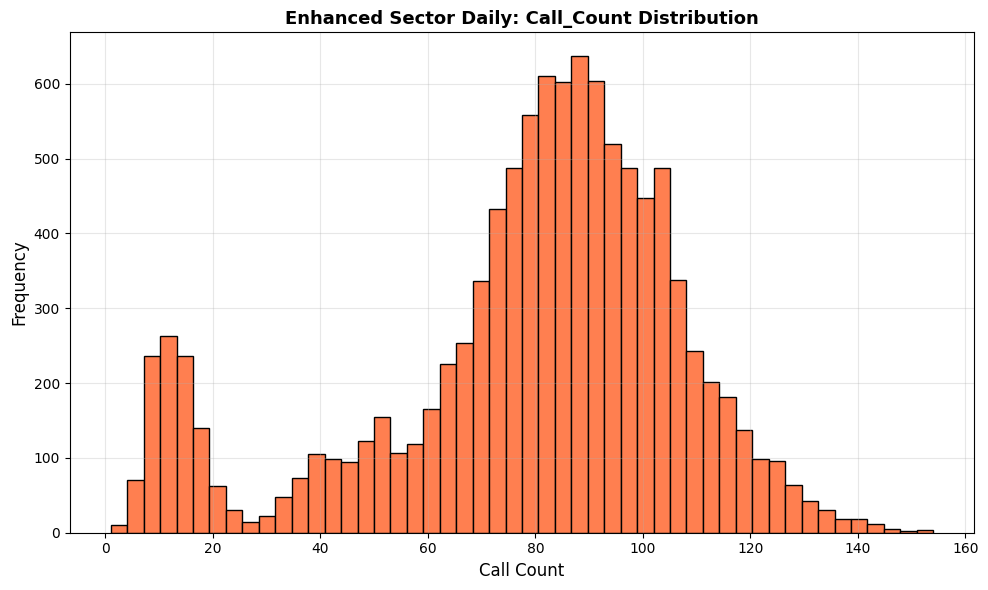

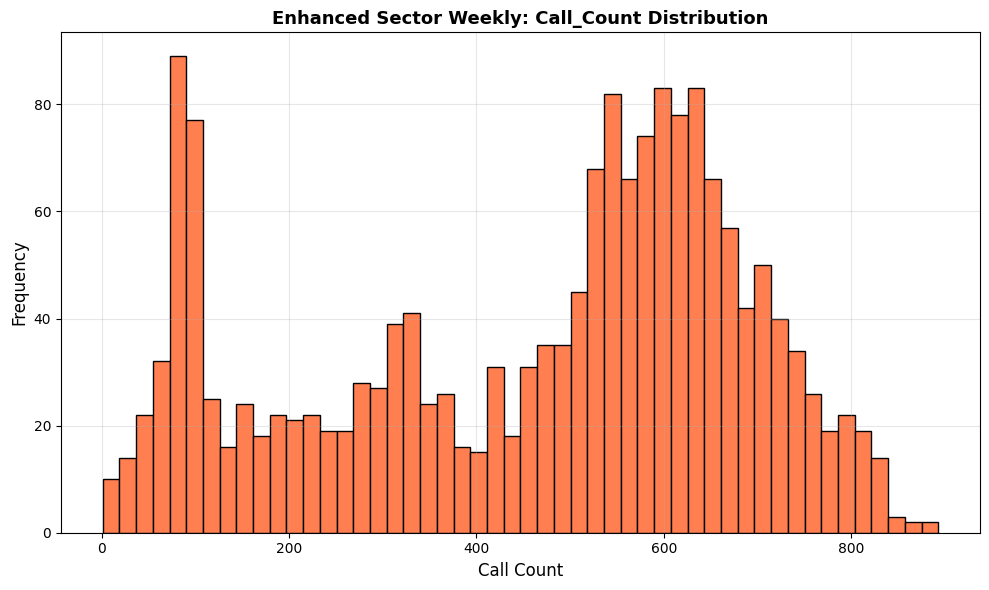

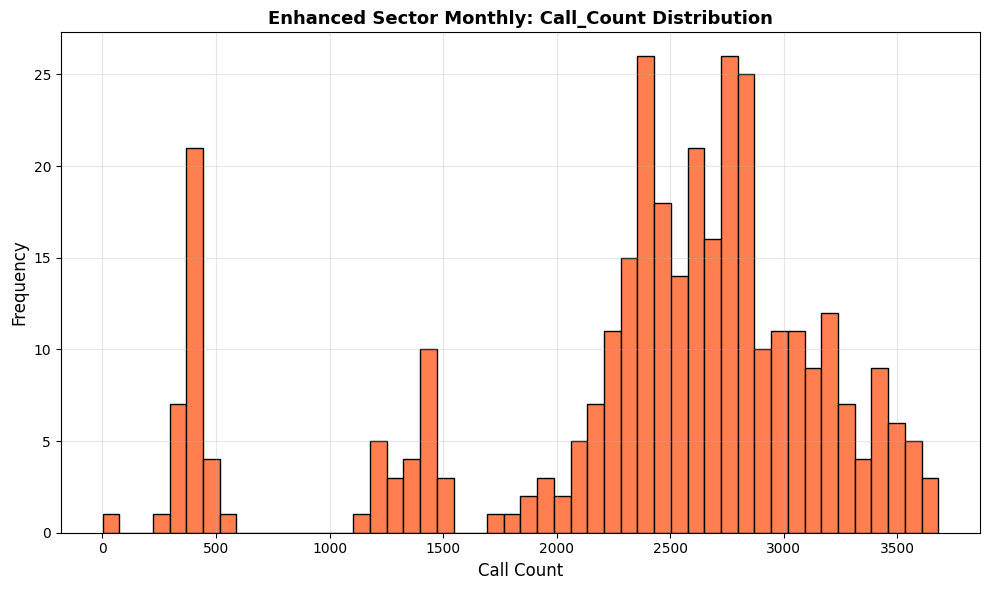

In [11]:
import os
os.makedirs('feature_engineering_comparison/Sector', exist_ok=True)

# Enhanced Daily histogram
plt.figure(figsize=(10, 6))
plt.hist(sector_daily['Call_Count'], bins=50, color='coral', edgecolor='black')
plt.xlabel('Call Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Enhanced Sector Daily: Call_Count Distribution', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('feature_engineering_comparison/Sector/enhanced_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Enhanced Weekly histogram
plt.figure(figsize=(10, 6))
plt.hist(sector_weekly['Call_Count'], bins=50, color='coral', edgecolor='black')
plt.xlabel('Call Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Enhanced Sector Weekly: Call_Count Distribution', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('feature_engineering_comparison/Sector/enhanced_weekly_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Enhanced Monthly histogram
plt.figure(figsize=(10, 6))
plt.hist(sector_monthly['Call_Count'], bins=50, color='coral', edgecolor='black')
plt.xlabel('Call Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Enhanced Sector Monthly: Call_Count Distribution', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('feature_engineering_comparison/Sector/enhanced_monthly_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## Save Feature-Engineered Datasets

Save the datasets with all engineered features for model training.


In [10]:
# Save datasets
sector_daily.to_csv('sector_daily_enhanced.csv', index=False)
sector_weekly.to_csv('sector_weekly_enhanced.csv', index=False)
sector_monthly.to_csv('sector_monthly_enhanced.csv', index=False)

print("Saved feature-engineered datasets:")
print(f"sector_daily_enhanced.csv ({len(sector_daily):,} rows, {len(sector_daily.columns)} columns)")
print(f"sector_weekly_enhanced.csv ({len(sector_weekly):,} rows, {len(sector_weekly.columns)} columns)")
print(f"sector_monthly_enhanced.csv ({len(sector_monthly):,} rows, {len(sector_monthly.columns)} columns)")

print(f"\nFeature Summary:")
print(f"Daily features: {len(sector_daily.columns) - 1} (excluding Call_Count)")
print(f"Weekly features: {len(sector_weekly.columns) - 1} (excluding Call_Count)")
print(f"Monthly features: {len(sector_monthly.columns) - 1} (excluding Call_Count)")
print(f"\n   Features include:")
print(f"   - Priority percentages (4 features)")
print(f"   - Mental Health percentage (1 feature)")
print(f"   - Top 5 category percentages (5 features)")
print(f"   - Lag features (5 for daily, 1+ for weekly, 2 for monthly)")
print(f"   - Temporal features (is_weekend, is_peak_day, is_holiday)")
print(f"   - Hour-based features (is_peak_hour_period, hour_category, hours_from_peak)")
print(f"   - Priority-hour interactions (pct_priority_1_peak_hour, is_high_priority_day)")
print(f"   - Trend features (days_since_start, year_trend, month_trend, week_trend)")
print(f"   - Rolling statistics (rolling_mean_7d, rolling_std_7d, rolling_mean_30d)")


Saved feature-engineered datasets:
sector_daily_enhanced.csv (10,351 rows, 51 columns)
sector_weekly_enhanced.csv (1,771 rows, 35 columns)
sector_monthly_enhanced.csv (341 rows, 35 columns)

Feature Summary:
Daily features: 50 (excluding Call_Count)
Weekly features: 34 (excluding Call_Count)
Monthly features: 34 (excluding Call_Count)

   Features include:
   - Priority percentages (4 features)
   - Mental Health percentage (1 feature)
   - Top 5 category percentages (5 features)
   - Lag features (5 for daily, 1+ for weekly, 2 for monthly)
   - Temporal features (is_weekend, is_peak_day, is_holiday)
   - Hour-based features (is_peak_hour_period, hour_category, hours_from_peak)
   - Priority-hour interactions (pct_priority_1_peak_hour, is_high_priority_day)
   - Trend features (days_since_start, year_trend, month_trend, week_trend)
   - Rolling statistics (rolling_mean_7d, rolling_std_7d, rolling_mean_30d)
